# Derivatives example
This example illustrate how to use the v parameter in MeanCVaR and MeanVariance.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
pnl = ft.load_pnl()
np.round(ft.simulation_moments(pnl), 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.096,3.023
Corp IG,-0.004,0.034,0.107,3.109
Corp HY,0.019,0.061,0.173,2.971
EM Debt,0.027,0.075,0.217,3.057
DM Equity,0.064,0.149,0.396,3.148
EM Equity,0.080,0.269,0.766,4.099
Private Equity,0.137,0.278,0.716,3.758
Infrastructure,0.059,0.108,0.311,3.193
Real Estate,0.043,0.081,0.234,3.092
Hedge Funds,0.048,0.072,0.204,3.050


In [3]:
# Price some options
put_90 = ft.put_option(1, 0.9, 0.16, 0, 1)
put_95 = ft.put_option(1, 0.95, 0.155, 0, 1)
put_atmf = ft.put_option(1, 1, 0.15, 0, 1)
call_atmf = ft.call_option(1, 1, 0.15, 0, 1)
call_105 = ft.call_option(1, 1.05, 0.145, 0, 1)
call_110 = ft.call_option(1, 1.1, 0.14, 0, 1)

# Compute relative P&L
S, I = pnl.shape
zeros_vec = np.zeros(S)
dm_equity_price = 1 + pnl['DM Equity'].values

put_90_pnl = np.maximum(zeros_vec, 0.9 - dm_equity_price) - put_90
put_95_pnl = np.maximum(zeros_vec, 0.95 - dm_equity_price) - put_95
put_atmf_pnl = np.maximum(zeros_vec, 1 - dm_equity_price) - put_atmf
call_atmf_pnl = np.maximum(zeros_vec, dm_equity_price - 1) - call_atmf
call_105_pnl = np.maximum(zeros_vec, dm_equity_price - 1.05) - call_105
call_110_pnl = np.maximum(zeros_vec, dm_equity_price - 1.1) - call_110

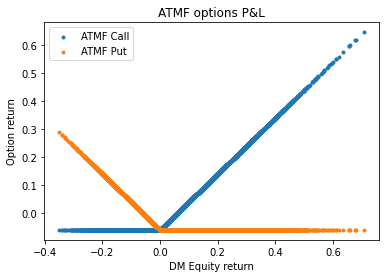

In [4]:
# Plot ATMF P&L vs underlying for illustration
plt.scatter(pnl['DM Equity'], call_atmf_pnl, marker='.')
plt.scatter(pnl['DM Equity'], put_atmf_pnl, marker='.')
plt.title('ATMF options P&L')
plt.legend(['ATMF Call', 'ATMF Put'])
plt.ylabel('Option return')
plt.xlabel('DM Equity return')
plt.show()

In [5]:
# Add option simulations to P&L
pnl['Put 90'] = put_90_pnl
pnl['Put 95'] = put_95_pnl
pnl['Put ATMF'] = put_atmf_pnl
pnl['Call ATMF'] = call_atmf_pnl
pnl['Call 105'] = call_105_pnl
pnl['Call 110'] = call_110_pnl

stats_prior = ft.simulation_moments(pnl)
np.round(stats_prior, 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.096,3.023
Corp IG,-0.004,0.034,0.107,3.109
Corp HY,0.019,0.061,0.173,2.971
EM Debt,0.027,0.075,0.217,3.057
DM Equity,0.064,0.149,0.396,3.148
EM Equity,0.080,0.269,0.766,4.099
Private Equity,0.137,0.278,0.716,3.758
Infrastructure,0.059,0.108,0.311,3.193
Real Estate,0.043,0.081,0.234,3.092
Hedge Funds,0.048,0.072,0.204,3.050


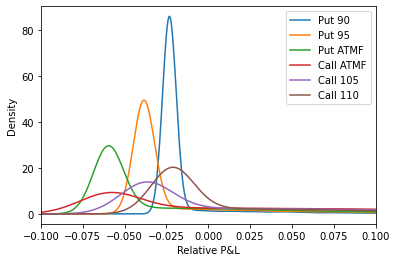

In [6]:
# Plot option P&L distributions
pnl.iloc[:, -6:].plot(kind='density')
plt.xlim([-0.1, 0.1])
plt.xlabel('Relative P&L')
plt.show()

# Prior portfolio optimization

In [7]:
# Optimization constraints
v = np.hstack((np.ones(I), [put_90, put_95, put_atmf, call_atmf, call_105, call_110]))
G = np.vstack((np.eye(len(v)), -np.eye(len(v))))
options_bounds = 0.5 * np.ones(6)
h = np.hstack((0.25 * np.ones(I), options_bounds, np.zeros(I), options_bounds))

In [8]:
R = pnl.values

alpha = 0.9
cvar_opt_prior = ft.MeanCVaR(R, G, h, v=v, alpha=alpha)

mean_prior = stats_prior['Mean'].values
cov_prior = ft.covariance_matrix(pnl).values
var_opt_prior = ft.MeanVariance(mean_prior, cov_prior, G, h, v=v)

port_cvar = cvar_opt_prior.efficient_portfolio(0.05)
port_var = var_opt_prior.efficient_portfolio(0.05)
prior_results = np.hstack((port_cvar, port_var))

portfolio_names = [f'{int(100 * alpha)}%-CVaR optimized', 'Variance optimized']
pd.DataFrame(
    np.round(100 * prior_results, 2), index=pnl.columns, columns=portfolio_names)

,90%-CVaR optimized,Variance optimized
Gov & MBS,-0.00,0.00
Corp IG,0.00,0.00
Corp HY,0.00,0.00
EM Debt,15.05,17.76
DM Equity,16.81,11.98
EM Equity,0.00,0.00
Private Equity,4.81,3.83
Infrastructure,18.60,22.82
Real Estate,18.44,21.94
Hedge Funds,25.00,25.00


In [9]:
print(f'Portfolio exposures: {np.round(np.sum(prior_results, axis=0), 2)}.')
print(f'Portfolio market values: {v @ prior_results}.')

Portfolio exposures: [1.35 0.16].
Portfolio market values: [1. 1.].


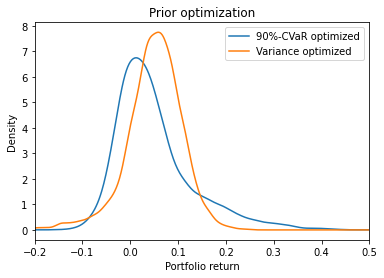

In [10]:
# Plot portfolio P&L distributions
pfs_pnl = pd.DataFrame(pnl.values @ prior_results, columns=portfolio_names)

pfs_pnl.plot(kind='density')
plt.title('Prior optimization')
plt.xlim([-0.2, 0.5])
plt.xlabel('Portfolio return')
plt.show()

In [11]:
np.round(np.min(pfs_pnl, axis=0), 2)

90%-CVaR optimized   -0.16
Variance optimized   -0.30
dtype: float64

In [12]:
np.round(np.max(pfs_pnl, axis=0), 2)

90%-CVaR optimized    0.57
Variance optimized    0.25
dtype: float64

# Entropy Pooling views

In [13]:
dm_eqt_pnl = pnl['DM Equity'].values[np.newaxis, :]
dm_eqt_mean = mean_prior[4]
dm_eqt_demean = dm_eqt_pnl - dm_eqt_mean
p = np.ones((S, 1)) / S

A_ep = np.vstack((
    np.ones((1, S)), dm_eqt_pnl, dm_eqt_demean**2,
    (dm_eqt_demean / 0.2)**3, (dm_eqt_demean / 0.2)**4))
b_ep = np.array([[1.], [dm_eqt_mean], [0.2**2], [-0.1], [2.75]])

q = ft.entropy_pooling(p, A_ep, b_ep)

In [14]:
stats_post = ft.simulation_moments(pnl, q)
np.round(stats_post, 3)

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.007,0.032,0.043,2.999
Corp IG,-0.004,0.033,0.152,3.140
Corp HY,0.017,0.071,-0.010,2.792
EM Debt,0.025,0.082,0.083,3.104
DM Equity,0.064,0.200,-0.100,2.750
EM Equity,0.080,0.326,0.571,4.035
Private Equity,0.142,0.339,0.441,3.247
Infrastructure,0.058,0.114,0.303,3.082
Real Estate,0.040,0.090,0.114,2.962
Hedge Funds,0.045,0.093,-0.220,3.012


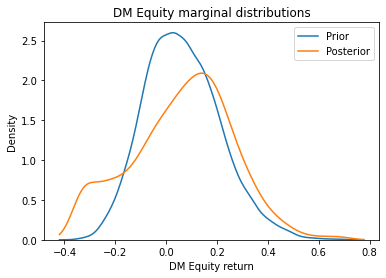

In [15]:
# Plot DM Equity P&L distribution
sns.kdeplot(pnl['DM Equity'])
sns.kdeplot(pnl['DM Equity'], weights=q[:, 0])
plt.title('DM Equity marginal distributions')
plt.legend(['Prior', 'Posterior'])
plt.xlabel('DM Equity return')
plt.show()

# Posterior portfolio optimization


In [16]:
cvar_opt_post = ft.MeanCVaR(R, G, h, v=v, p=q, alpha=alpha)

mean_post = stats_post['Mean'].values
cov_post = ft.covariance_matrix(R, q)
var_opt_post = ft.MeanVariance(mean_post, cov_prior, G, h, v=v)

port_cvar_post = cvar_opt_post.efficient_portfolio(0.05)
port_var_post = var_opt_post.efficient_portfolio(0.05)
post_results = np.hstack((port_cvar_post, port_var_post))

In [17]:
pd.DataFrame(
    np.round(100 * post_results, 2), index=pnl.columns, columns=portfolio_names)

,90%-CVaR optimized,Variance optimized
Gov & MBS,18.56,0.00
Corp IG,0.00,0.00
Corp HY,0.00,0.00
EM Debt,7.05,16.81
DM Equity,25.00,6.26
EM Equity,0.00,0.00
Private Equity,2.70,5.13
Infrastructure,9.94,24.13
Real Estate,9.37,19.45
Hedge Funds,25.00,25.00


In [18]:
print(f'Posterior portfolio exposures: {np.round(np.sum(post_results, axis=0), 2)}.')
print(f'Posterior portfolio market values: {v @ post_results}.')

Posterior portfolio exposures: [1.89 2.07].
Posterior portfolio market values: [1. 1.].


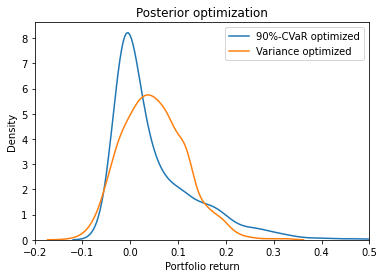

In [19]:
pfs_pnl_post = pnl @ post_results
pfs_pnl_post.columns = portfolio_names

sns.kdeplot(pfs_pnl_post.values[:, 0], weights=q[:, 0])
sns.kdeplot(pfs_pnl_post.values[:, 1], weights=q[:, 0])
plt.title('Posterior optimization')
plt.legend(portfolio_names)
plt.xlabel('Portfolio return')
plt.xlim([-0.2, 0.5])
plt.show()

In [20]:
np.round(np.min(pfs_pnl_post, axis=0), 2)

90%-CVaR optimized   -0.08
Variance optimized   -0.14
dtype: float64

In [21]:
np.round(np.max(pfs_pnl_post, axis=0), 2)

90%-CVaR optimized    0.54
Variance optimized    0.33
dtype: float64

# License

In [22]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2022 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.